In [1]:
# Importing packages
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python

import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import random
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from matplotlib import gridspec

import itertools
from itertools import combinations

# Setting directory
# os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_test") # set the working directory

Reading in data!

In [2]:
# Importing data
data_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/CostaRica_Chemistry_20200518.csv'
data_2_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/lia_Q.csv' # DS Q
data_3_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/UpQDataSlam.csv'# US Q
data_4_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/down_q_measured.csv'# DS Q Measured
data_5_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/up_q_measured.csv'# US Q Measured
data_6_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/DownstreamMiller.csv' # Rain
data_7_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Ratios/Ratios.csv' # US/DS ratios
data_8_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Well_SWH.csv' # Well data

# Read data from url as pandas dataframe
df = pd.read_csv(data_url)
df2 = pd.read_csv(data_2_url)
df3 = pd.read_csv(data_3_url)
df4 = pd.read_csv(data_4_url)
df5 = pd.read_csv(data_5_url)
df6 = pd.read_csv(data_6_url)
df7 = pd.read_csv(data_7_url)
df8 = pd.read_csv(data_8_url)

# Making date columns datetime friendly (in case I wanted to index later)
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['Chemetrics_Acidified_Date'] = pd.to_datetime(df['Chemetrics_Acidified_Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])
df5['Date'] = pd.to_datetime(df5['Date'])
df6['Date'] = pd.to_datetime(df6['Date'])
df8['Date'] = pd.to_datetime(df8['Date'])

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring
df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True) # Endmember 3b = Upstream, not including 2019

# Filtering mixing batches
df_ds = df[(df['Site'] == "Downstream") & (df['SamplingDate'] < '2019')] # Mixing batch a, not including 2019
df_ds = df_ds[~df_ds['ID'].str.contains("Howler")] # Only want the DS samples
df_ds = df_ds[~df_ds['ID'].str.contains("DS9Bot")].reset_index(drop=True) # Filtering out DS9Bot (duplicate)
df_stream = df[(df['Source'] == "Stream") & (df['SamplingDate'] < '2019')].reset_index() # Mixing batch b, not including 2019

# Summary statistics:
df_summary = df.groupby("Site").describe()

# For this analysis, I'm dropping the US samples that are missing 
# from the DS samples (because the ISCO was not installed correctly):
# Samples 4 - 8
df_us = df_us.drop(df_us.index[3:8]).reset_index(drop=True)
# df_us = df_us.drop(df_us.index[4]).reset_index(drop=True) # Dropping sample 10
# df_ds = df_ds.drop(df_ds.index[4]).reset_index(drop=True) # Dropping sample 10

Setting up a running mean function

In [3]:
# Running mean function
def running_mean(in_array,window):
    import numpy as np
    w = int(np.floor(window/2))
    mean_array = np.zeros(len(in_array),dtype=np.float64)
    i = int(w)
    while i < len(in_array)-w:
        mean_array[i] = np.mean(in_array[(i-w):(i+w+1)])
        i += 1
    window_used = int(w*2 +1)
    return(mean_array,window_used)

In [4]:
# Adding running mean to US and DS hydrograph
ds_q = df2['Q'].to_numpy() # taking discharge values
rm_ds_q = running_mean(ds_q, 5) # returns 2-D array with running mean, making first two values and last two values 0, AND returning the window used.

us_q = df3['Q'].to_numpy()
rm_us_q = running_mean(us_q, 5)

df2['MovingAverage5'] = rm_ds_q[0]  # only care about first array with moving average
df3['MovingAverage5'] = rm_us_q[0] 

df2['MovingAverage5'] = df2['MovingAverage5'].replace([0], np.nan) # replace first and last two values with NaNs
df3['MovingAverage5'] = df3['MovingAverage5'].replace([0], np.nan)

[Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '0')]

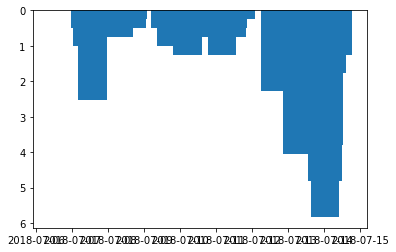

In [5]:
# Rain df6
df6_copy = df6.copy()
df6_copy['Rain'] = -1 * df6_copy['Rain']

fig, ax = plt.subplots()
ax.bar(df6_copy['Date'], df6_copy['Rain'])
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])

# plt.show()

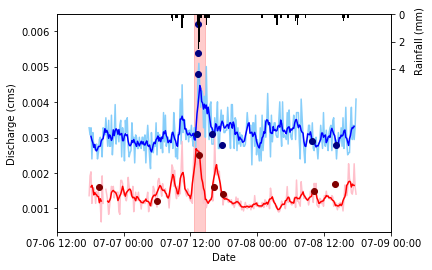

In [6]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

# ax1.xaxis.set_major_locator(hours)
# ax1.xaxis.set_major_formatter(h_fmt)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")

ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-16,-0)
ax2.set_yticks([-4,-2,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cms)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)


t = ax2.text(1.1, 0.88, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()
# plt.ylim(8,12)
# plt.xlim(0,2000)

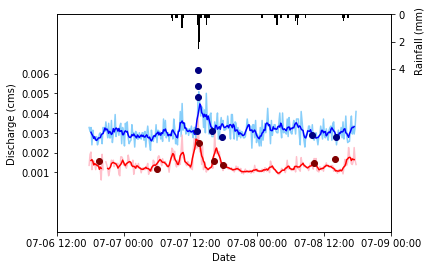

In [8]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

# ax1.xaxis.set_major_locator(hours)
# ax1.xaxis.set_major_formatter(h_fmt)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")


ax1.set_ylim(-0.002,0.009)
ax1.set_yticks([0.001,0.002,0.003,0.004,0.005,0.006])


ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-16,-0)
ax2.set_yticks([-4,-2,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

# ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cms)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)


t = ax2.text(1.1, 0.88, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()